### Importing Dependencies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

### Importing Data

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
store_df = pd.read_csv('store.csv')

In [5]:
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
test_df.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [7]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [8]:
print(f"Shape of train data: {train_df.shape}")
print(f"Shape of test  data: {test_df.shape}")
print(f"Shape of store data: {store_df.shape}")

Shape of train data: (1017209, 9)
Shape of test  data: (41088, 8)
Shape of store data: (1115, 10)


### Joining

In [9]:
# check if the stores in the train and store dataset align
train_df.Store.nunique() == store_df.Store.nunique()

True

In [11]:
df = train_df.merge(store_df, how='left', left_on=train_df.Store, right_on=store_df.Store)
df.head()

,key_0,Store_x,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Store_y,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,5,2015-07-31,5263,555,1,1,0,1,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,2,5,2015-07-31,6064,625,1,1,0,1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,3,5,2015-07-31,8314,821,1,1,0,1,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,4,5,2015-07-31,13995,1498,1,1,0,1,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,5,2015-07-31,4822,559,1,1,0,1,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [12]:
df.drop(['key_0', 'Store_y'], axis=1, inplace=True)
df = df.rename(columns={'Store_x':'Store'})
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [13]:
df.shape

(1017209, 18)

### Understanding the Data

In [14]:
round(df.describe().T, 2)

,count,mean,std,min,25%,50%,75%,max
Store,1017209.0,558.43,321.91,1.0,280.0,558.0,838.0,1115.0
DayOfWeek,1017209.0,4.00,2.00,1.0,2.0,4.0,6.0,7.0
Sales,1017209.0,5773.82,3849.93,0.0,3727.0,5744.0,7856.0,41551.0
Customers,1017209.0,633.15,464.41,0.0,405.0,609.0,837.0,7388.0
Open,1017209.0,0.83,0.38,0.0,1.0,1.0,1.0,1.0
Promo,1017209.0,0.38,0.49,0.0,0.0,0.0,1.0,1.0
SchoolHoliday,1017209.0,0.18,0.38,0.0,0.0,0.0,0.0,1.0
CompetitionDistance,1014567.0,5430.09,7715.32,20.0,710.0,2330.0,6890.0,75860.0
CompetitionOpenSinceMonth,693861.0,7.22,3.21,1.0,4.0,8.0,10.0,12.0
CompetitionOpenSinceYear,693861.0,2008.69,5.99,1900.0,2006.0,2010.0,2013.0,2015.0


There are in total 1115 stores with sales feature having 3849.93 volatility and feature customers having 464.41 volatility with a mean of 5773.82 and 633.15 respectively.

In [15]:
train_df.duplicated().sum(), test_df.duplicated().sum()

(0, 0)

In [16]:
train_df.isnull().sum().sum(), test_df.isnull().sum().sum()

(0, 11)

There are no duplicates and Testing dataset has 11 null values.

In [18]:
print("Training data starts from: {}".format(train_df.Date.min()))
print("Training data end on: {}".format(train_df.Date.max()))
print()
print("Testing data starts from: {}".format(test_df.Date.min()))
print("Testing data end on: {}".format(test_df.Date.max()))

Training data starts from: 2013-01-01
Training data end on: 2015-07-31

Testing data starts from: 2015-08-01
Testing data end on: 2015-09-17


### Exploratory Data Analysis

In [19]:
df.Date = pd.to_datetime(df.Date)
df['Day'] = df.Date.dt.day
df['Month'] = df.Date.dt.month
df['Year'] = df.Date.dt.year
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Day,Month,Year
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,1270.0,9.0,2008.0,0,NaN,NaN,NaN,31,7,2015
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",31,7,2015
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",31,7,2015
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,620.0,9.0,2009.0,0,NaN,NaN,NaN,31,7,2015
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,29910.0,4.0,2015.0,0,NaN,NaN,NaN,31,7,2015


Let's explore the seasonality and trend in the dataset.

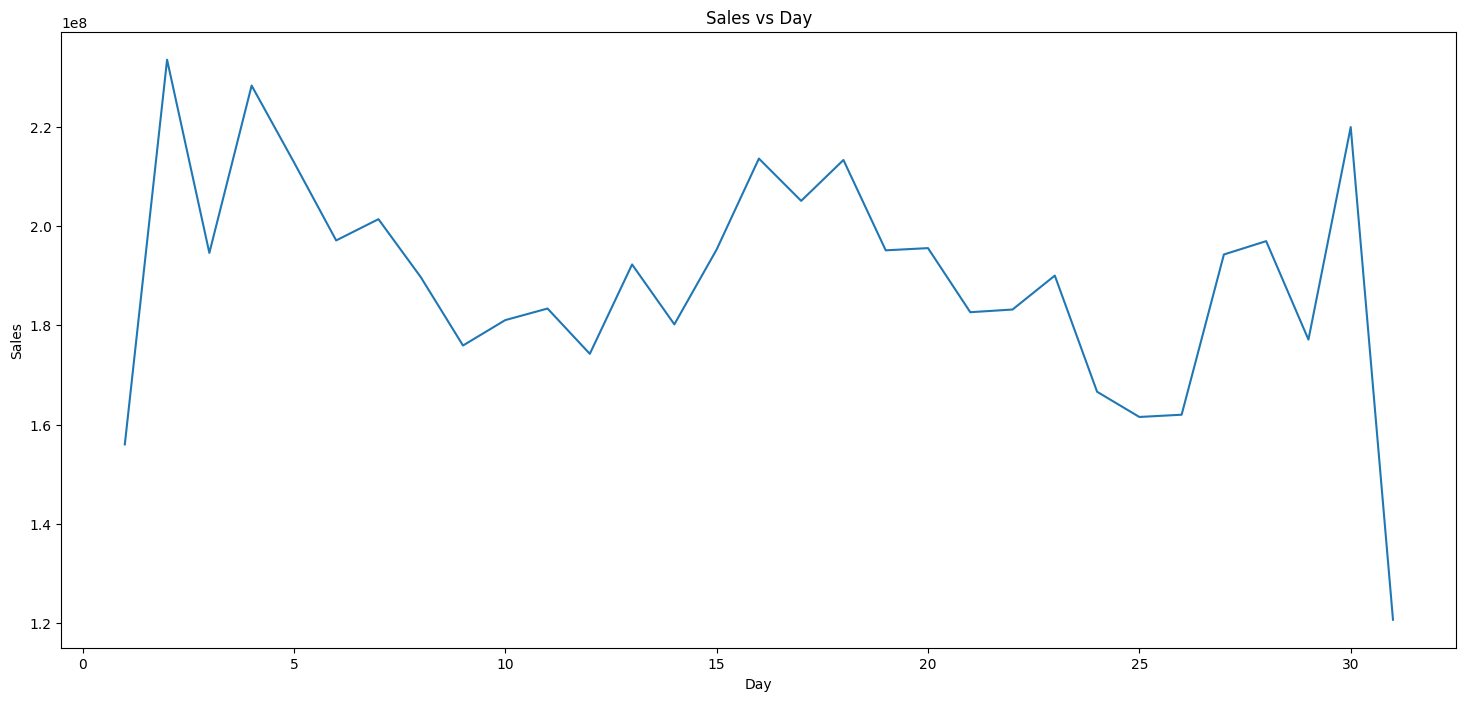

In [26]:
plt.figure(figsize=(18,8))
plt.plot(df.groupby('Day')['Sales'].sum())
plt.title("Sales vs Day")
plt.xlabel("Day")
plt.ylabel("Sales")
plt.show()

From the graph above we see that most sales are done in the beginning of the month with end of the month being the lowest.

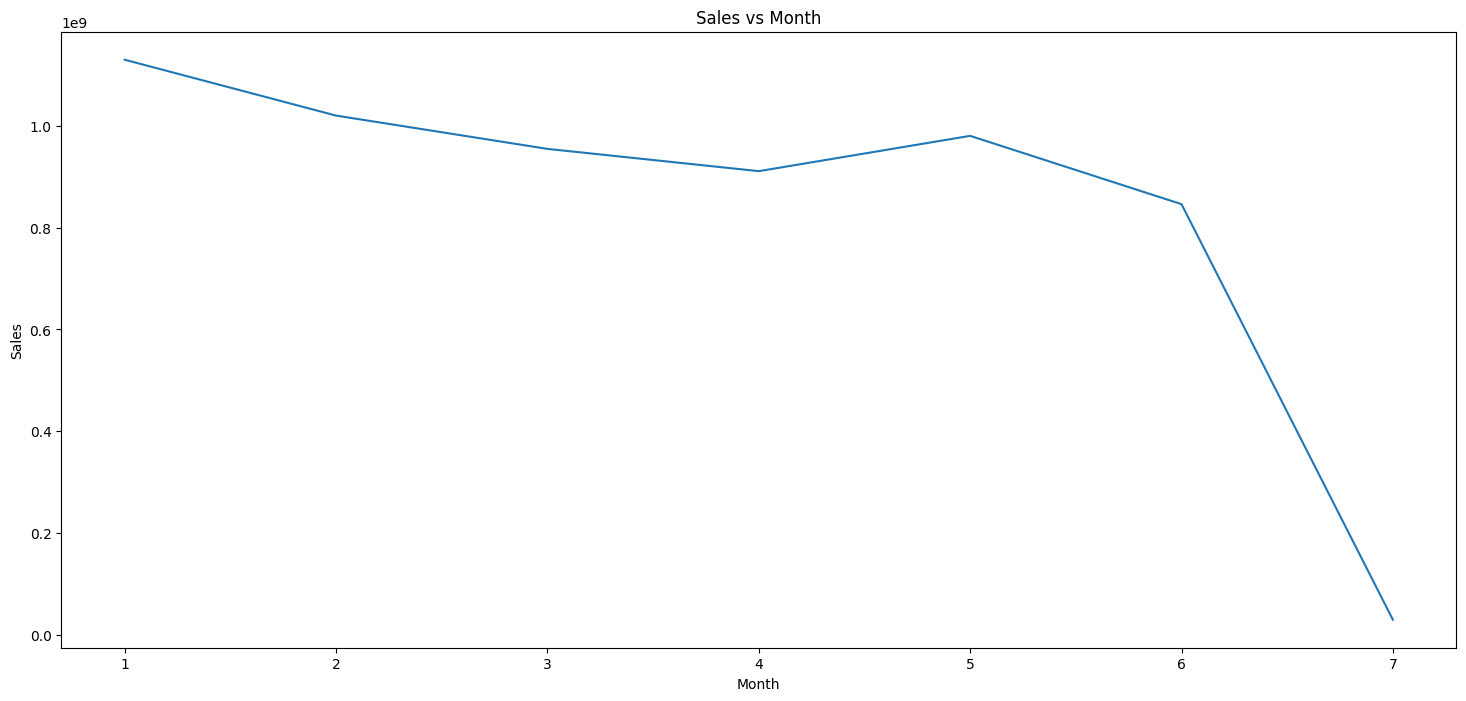

In [29]:
plt.figure(figsize=(18,8))
plt.plot(df.groupby('DayOfWeek')['Sales'].sum())
plt.title("Sales vs Month")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.show()

Sales are more in the beginning of the week than the end.

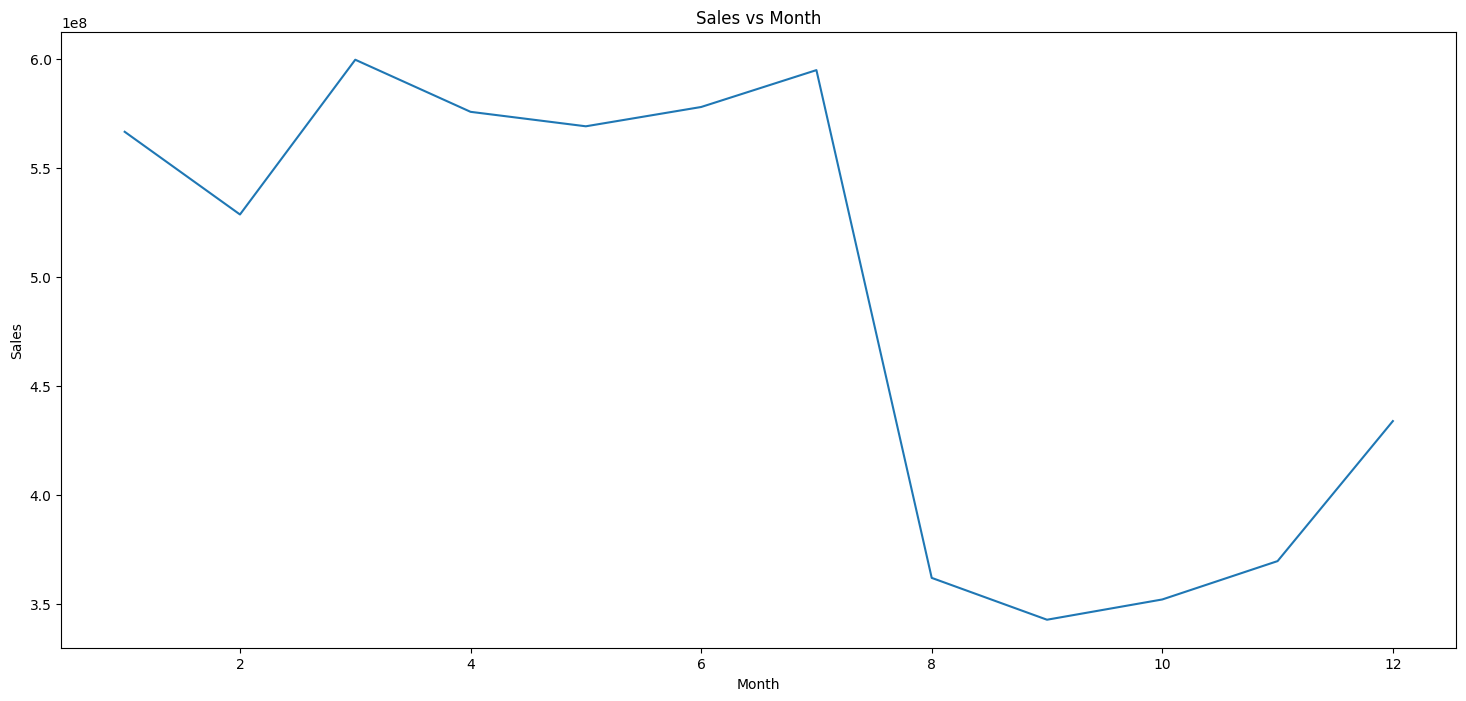

In [30]:
plt.figure(figsize=(18,8))
plt.plot(df.groupby('Month')['Sales'].sum())
plt.title("Sales vs Month")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.show()

Sales are relatively lower by the end of year.

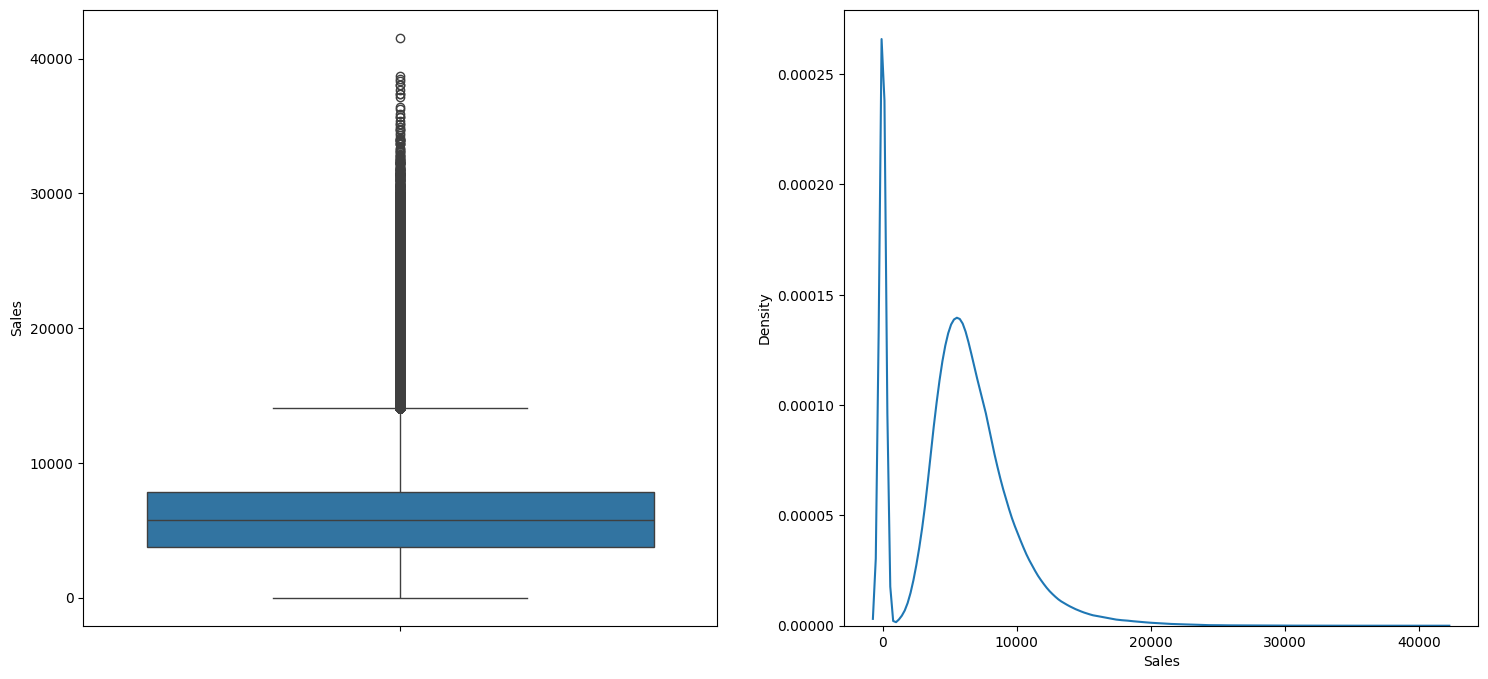

In [31]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
sns.boxplot(train_df.Sales, ax=ax1)
sns.kdeplot(train_df.Sales, ax=ax2)
plt.show()

Sales are 0 on a huge amount of days which could mean this is either imputed to fill gaps as it doesn't make sense for sales of a day to be 0! This could mean the store was closed on holidays. Let's test it out.

In [32]:
df[df.Open==0].Sales.value_counts()

Sales
0    172817
Name: count, dtype: int64

Seems like the above hypothesis is right. 172,817 values are filled with 0. Let's fill these values with `np.NaN` as some models like `XGBoost` can handle missing values and it might benefit from it.

In [36]:
# Remove non-numeric columns from train_df and test_df
train_df_numeric = train_df.select_dtypes(include=[np.number])
test_df_numeric = test_df.select_dtypes(include=[np.number])

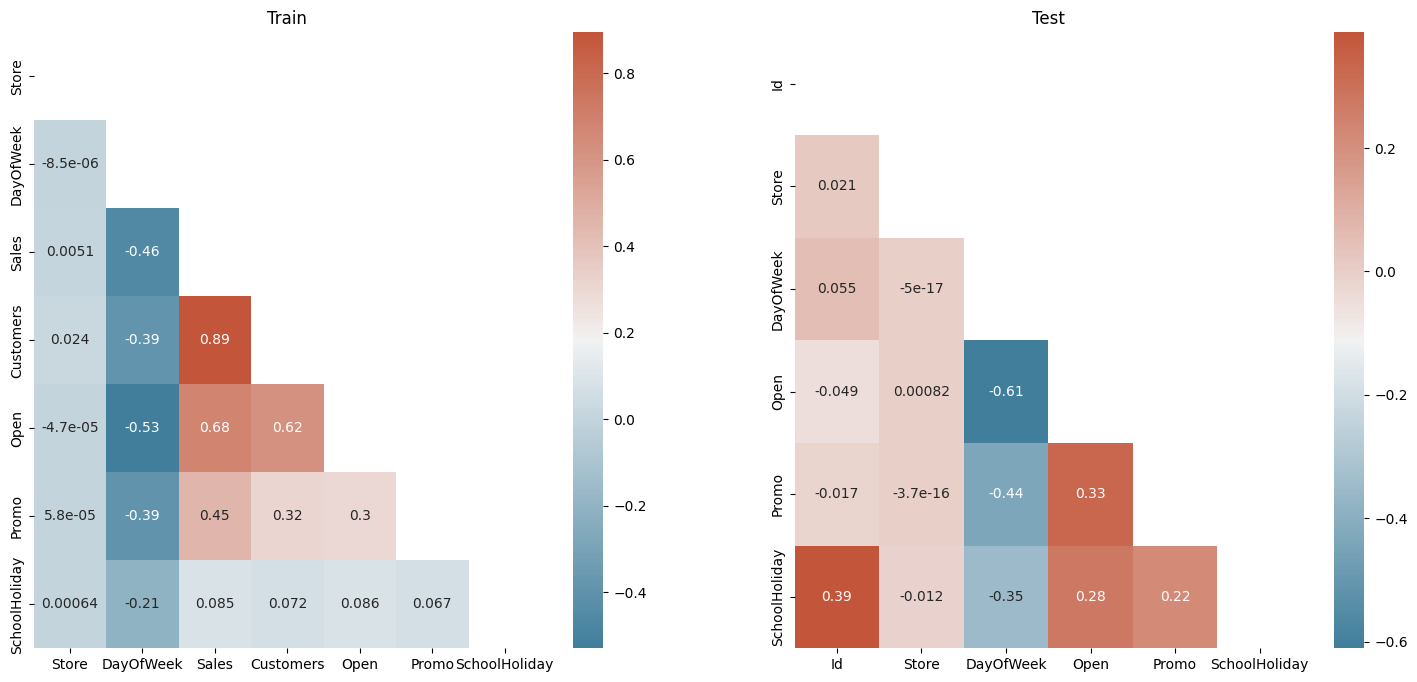

In [37]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

corr_train = train_df_numeric.corr()
mask_train = np.triu(np.ones_like(corr_train, dtype=bool))
sns.heatmap(corr_train, mask=mask_train, cmap=cmap, annot=True, ax=ax1)
ax1.set_title('Train')

corr_test = test_df_numeric.corr()
mask_test = np.triu(np.ones_like(corr_test, dtype=bool))
sns.heatmap(corr_test, mask=mask_test, cmap=cmap, annot=True, ax=ax2)
ax2.set_title('Test')

plt.show()

We see that sales are highly correlated with feature `Customers` and feature `Open` and moderately correlated with `Promo`. Let's see some more plots about this.